<a href="https://colab.research.google.com/github/tsnthlg/CapStone/blob/master/MultivarLSTM%20Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Load the time series data from "time_series.csv", predict one of the time series based on all three, and evaluate the prediction.

## Load and inspect data

### Subtask:
Load the time series data from the file into a pandas DataFrame and display the first few rows and the data types to understand the structure of the data.


**Reasoning**:
Load the time series data into a pandas DataFrame and display the first few rows and data types.



In [43]:
import pandas as pd

df = pd.read_csv('/content/synthetic_timeseries.csv')
display(df.head())
display(df.info())

,feature1,feature2,target
0,0.049671,0.858463,0.318153
1,0.086007,0.952940,0.384964
2,0.263438,0.945795,0.523763
3,0.447823,0.875109,0.591824
4,0.366003,0.904932,0.316714


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  100 non-null    float64
 1   feature2  100 non-null    float64
 2   target    100 non-null    float64
dtypes: float64(3)
memory usage: 2.5 KB


None

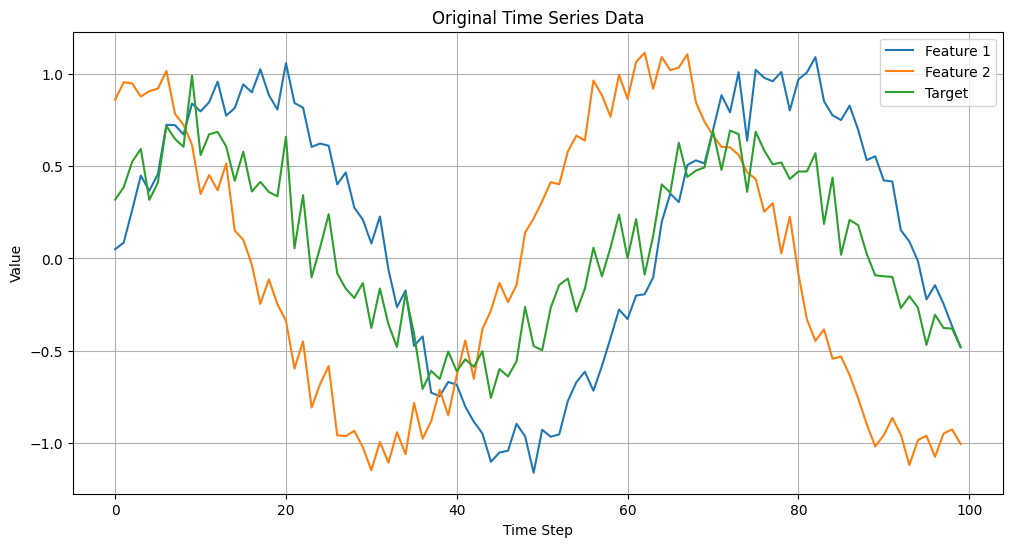

In [44]:
# @title
import matplotlib.pyplot as plt

# Plot the original time series
plt.figure(figsize=(12, 6))
plt.plot(df['feature1'], label='Feature 1')
plt.plot(df['feature2'], label='Feature 2')
plt.plot(df['target'], label='Target')
plt.title('Original Time Series Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## Data preprocessing

### Subtask:
Prepare the data for modeling by splitting the data into training and testing sets, handling missing values if necessary, and potentially scaling the data.


**Reasoning**:
Prepare the data for modeling by splitting into features and target, then splitting into training and testing sets, checking for missing values, and finally scaling the features.



In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Split into features (X) and target (y)
X = df[['feature1', 'feature2', 'target']].drop('target', axis=1)
y = df['target']

# 2. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Check for missing values (based on previous inspection, there should be none)
print("Missing values in X_train:", X_train.isnull().sum().sum())
print("Missing values in X_test:", X_test.isnull().sum().sum())
print("Missing values in y_train:", y_train.isnull().sum())
print("Missing values in y_test:", y_test.isnull().sum())

# 4. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display the shapes of the resulting sets to verify the split
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
print("\nFirst 5 rows of scaled X_train:\n", X_train_scaled[:5])


Missing values in X_train: 0
Missing values in X_test: 0
Missing values in y_train: 0
Missing values in y_test: 0

Shape of X_train: (80, 2)
Shape of X_test: (20, 2)
Shape of y_train: (80,)
Shape of y_test: (20,)

First 5 rows of scaled X_train:
 [[-1.14996519  0.88213945]
 [ 0.59286359 -1.1294019 ]
 [ 0.39253193 -1.20835421]
 [-1.56227927 -0.80823482]
 [ 0.56542955  1.01744464]]


## Data preprocessing for lstm

### Subtask:
Prepare the data specifically for an LSTM model by creating sequences and splitting the data into training and testing sets, handling missing values if necessary, and potentially scaling the data.


**Reasoning**:
Define a function to create sequences for LSTM input and apply it to the scaled training data to generate sequences and corresponding target values.



In [46]:
import numpy as np
import pandas as pd # Ensure pandas is imported if not already

def create_sequences(data, sequence_length):
    """
    Creates sequences from time series data for LSTM input.

    Args:
        data (pd.DataFrame): The input time series data containing all features and target.
        sequence_length (int): The length of the sequences.

    Returns:
        tuple: A tuple containing:
            - X (np.ndarray): The feature sequences (including the target in the features).
            - y (np.ndarray): The target values corresponding to the sequence's end.
    """
    X, y = [], []
    for i in range(len(data) - sequence_length):
        # Include all columns (feature1, feature2, target) in the sequence features
        X.append(data.iloc[i:(i + sequence_length)][['feature1', 'feature2', 'target']].values)
        # The target for prediction is the value at the end of the sequence
        y.append(data.iloc[i + sequence_length]['target'])
    return np.array(X), np.array(y)

# Specify the sequence length
sequence_length = 10

# Convert scaled training data back to DataFrame for easier slicing in the function
# The scaled data (X_train_scaled) contains only features. We need to add the target (y_train)
# back to create the combined data for sequences that include the target as a feature.

# Create a DataFrame from the scaled features.
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=['feature1', 'feature2'])

# Reset the index of y_train to ensure alignment with X_train_scaled_df
y_train_reset = y_train.reset_index(drop=True)

# Combine the scaled features and the target into a single DataFrame
# Ensure the column names are correct after combining
train_data_for_sequences = pd.concat([X_train_scaled_df, y_train_reset.rename('target')], axis=1)


# Generate sequences for training data
X_train_sequences, y_train_sequences = create_sequences(train_data_for_sequences, sequence_length)

# Display the shapes of the generated sequences
print("Shape of X_train_sequences:", X_train_sequences.shape)
print("Shape of y_train_sequences:", y_train_sequences.shape)


Shape of X_train_sequences: (70, 10, 3)
Shape of y_train_sequences: (70,)


**Reasoning**:
Generate sequences for the testing data using the defined function and then split the generated sequences and target values into training and testing sets.



**Reasoning**:
Modify the TensorFlow windowing to create sequences with the next 4 target values as the output, enabling multi-step forecasting.

In [47]:
import tensorflow as tf

# Combine the scaled training features and target into a single numpy array
train_data_combined = train_data_for_sequences.values

# Create a TensorFlow dataset from the combined training data
dataset = tf.data.Dataset.from_tensor_slices(train_data_combined)

# Create windowed sequences
# The window size now needs to accommodate the input sequence and the 4 future target values.
# So, window_size = sequence_length (for input) + 4 (for future targets)
forecast_horizon = 4
window_size = sequence_length + forecast_horizon

# Create windows
dataset = dataset.window(window_size, shift=1, drop_remainder=True)

# Flatten the windows and split into features (X) and target (y)
dataset = dataset.flat_map(lambda window: window.batch(window_size))

# The features are the first 'sequence_length' steps of the window (all columns)
# The target is the 'target' column for the last 'forecast_horizon' steps of the window.
dataset = dataset.map(lambda window: (window[:sequence_length], window[sequence_length:, -1]))


# Shuffle and batch the dataset for training
batch_size = 32
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(1)

# Display the structure of the resulting dataset
for x, y in dataset.take(1):
    print("Shape of features (X) in a batch:", x.shape)
    print("Shape of target (y) in a batch:", y.shape)
    print("\nFirst batch of features (X):\n", x.numpy())
    print("\nFirst batch of targets (y):\n", y.numpy())

Shape of features (X) in a batch: (32, 10, 3)
Shape of target (y) in a batch: (32, 4)

First batch of features (X):
 [[[-1.80079987 -0.26347892 -0.63812625]
  [ 0.59032902  1.15457418  0.47459163]
  [-0.52297836  1.43946673  0.21227633]
  [-0.59140087 -1.19661041 -0.37619531]
  [ 1.00139305  0.34255568  0.4293653 ]
  [-1.43739433 -0.53675084 -0.54527669]
  [-0.87440235  1.05161009  0.05856077]
  [-1.68208029  0.22928837 -0.26244802]
  [-0.77463482 -1.16723525 -0.3790793 ]
  [-1.10304895  1.20343538 -0.09694151]]

 [[-0.77463482 -1.16723525 -0.3790793 ]
  [-1.10304895  1.20343538 -0.09694151]
  [ 1.3364577   0.60936757  0.68511155]
  [-0.30823111 -1.40331768 -0.35666229]
  [-0.23925761 -1.2430378  -0.26622863]
  [-0.63810621  1.34913397  0.23724247]
  [-0.37384555  1.25027184  0.12149498]
  [ 0.96113319 -0.66471901  0.43768763]
  [-1.3226573  -1.10910786 -0.608348  ]
  [ 0.10267502 -1.29412098 -0.13339197]]

 [[ 0.10267502 -1.29412098 -0.13339197]
  [-0.08628577  1.29639304  0.38496384]

**Reasoning**:
Design and compile an LSTM model using TensorFlow/Keras for multi-step time series forecasting.

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten

# Define the LSTM model with Conv1D and additional LSTM layer
model = Sequential()
# Add Conv1D layer - requires an input shape (sequence_length, number_of_features)
# We'll use a small kernel size, e.g., 3
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, X_train_sequences.shape[2])))
# Add a MaxPooling1D layer to reduce the sequence length after convolution (optional but common)
model.add(MaxPooling1D(pool_size=2))
# Flatten the output of the Conv1D and MaxPooling layers to feed into the LSTM
model.add(Flatten())
# Add the first LSTM layer
# The input shape for the first LSTM after Conv1D needs to be adjusted based on the output of Conv1D and MaxPooling
# We'll need to reshape the output of the Flatten layer to be 3D (batches, timesteps, features)
# Let's redefine the model structure to handle this sequencing correctly, or use the functional API for more complex flows.
# For simplicity with Sequential, let's stick to the original input shape logic for LSTM directly after Conv1D if possible,
# or adjust the sequence_length after pooling if that's the intent.

# *Correction*: For Sequential model with Conv1D -> LSTM, the output of Conv1D needs to be treated as a sequence for LSTM.
# This typically involves ensuring the Conv1D output still has a time dimension or reshaping.
# A common pattern is Conv1D -> LSTM. The Conv1D output can be directly fed to LSTM if the LSTM
# expects input in the shape (batches, timesteps, features). Conv1D can output (batches, new_timesteps, filters).
# Let's adjust the model definition for Conv1D directly feeding into LSTM.

model = Sequential()
# Conv1D layer with input shape (sequence_length, number_of_features)
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, X_train_sequences.shape[2])))
# Add the first LSTM layer
# The output of Conv1D is (batches, new_timesteps, filters). This can be fed directly to LSTM.
model.add(LSTM(50, activation='relu', return_sequences=True)) # return_sequences=True to stack another LSTM layer
# Add the second LSTM layer
model.add(LSTM(50, activation='relu')) # No return_sequences=True for the last LSTM before Dense
# Add the first Dense layer
model.add(Dense(50, activation='relu'))
# Add the output Dense layer with 'forecast_horizon' neurons for multi-step prediction
model.add(Dense(forecast_horizon))

# Compile the model
model.compile(optimizer='adam', loss='mse') # Using Adam optimizer and Mean Squared Error loss

# Display the model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 8, 64)          │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 8, 50)          │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,594 (182.01 KB)

 Trainable params: 46,594 (182.01 KB)

 Non-trainable params: 0 (0.00 B)

**Reasoning**:
Define a learning rate scheduler callback to dynamically adjust the learning rate during training.

In [49]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the Learning Rate scheduler callback
# This will reduce the learning rate by a factor of 0.1 if the validation loss
# does not improve for 10 consecutive epochs.
lr_scheduler = ReduceLROnPlateau(
    monitor='loss',  # Monitor training loss
    factor=0.1,      # Reduce learning rate by this factor
    patience=10,     # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.0001,   # Lower bound on the learning rate
    verbose=1        # Print messages when learning rate is reduced
)

**Reasoning**:
Train the designed LSTM model for 100 epochs using the windowed dataset and record the training history.

In [55]:
# Train the model
history = model.fit(dataset, epochs=500, callbacks=[lr_scheduler])

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1038 - learning_rate: 0.0010
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1092 - learning_rate: 0.0010
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1063 - learning_rate: 0.0010
Epoch 4/500
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0910

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1004 - learning_rate: 0.0010
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1027 - learning_rate: 0.0010
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1035 - learning_rate: 0.0010
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1028 - learning_rate: 0.0010
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1081 - learning_rate: 0.0010
Epoch 9/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1110 - learning_rate: 0.0010
Epoch 10/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1042 - learning_rate: 0.0010
Epoch 11/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1081 - learning_rate: 0.0010
Epoch 12/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1222 - learning_rate: 0.0010
Epoch 13/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1065 - learning_rate: 0.0010
Epoch 14/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1042 - learning_rate: 0.0010
Epoch 15/500
1/3 ━━━━━━━━━━

**Reasoning**:
Plot the training loss over epochs to visualize the model's learning progress.

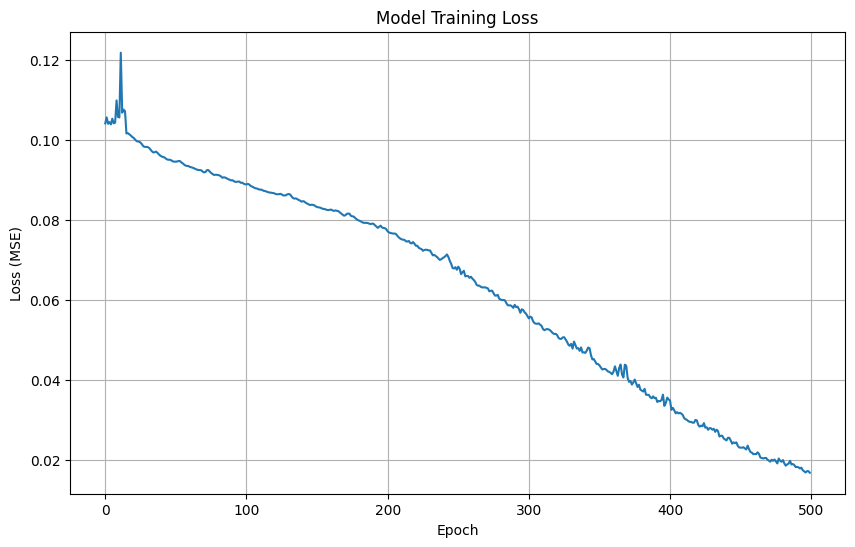

In [56]:
import matplotlib.pyplot as plt

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.show()

**Reasoning**:
Prepare the test data for prediction using the same windowing approach as the training data, make predictions using the trained LSTM model, and display the actual and predicted values.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Forecast (first 5 multi-step predictions):
 [[-0.05078432 -0.15777147  0.29679394 -0.01195478]
 [-0.45927227 -0.14831918  0.4107524  -0.15424956]
 [-0.00153367 -0.11407457  0.26754048  0.269523  ]
 [ 0.0402964  -0.13461383  0.24051487  0.21096152]
 [ 0.17924967  0.19070859  0.19664113  0.18715   ]]

Actuals (corresponding first 5 multi-step actual values):
 [[ 0.22282759 -0.09124024  0.3567189  -0.13518767]
 [-0.09124024  0.3567189  -0.13518767  0.02813707]
 [ 0.3567189  -0.13518767  0.02813707  0.20471631]
 [-0.13518767  0.02813707  0.20471631  0.31889292]
 [ 0.02813707  0.20471631  0.31889292  0.28674414]]


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


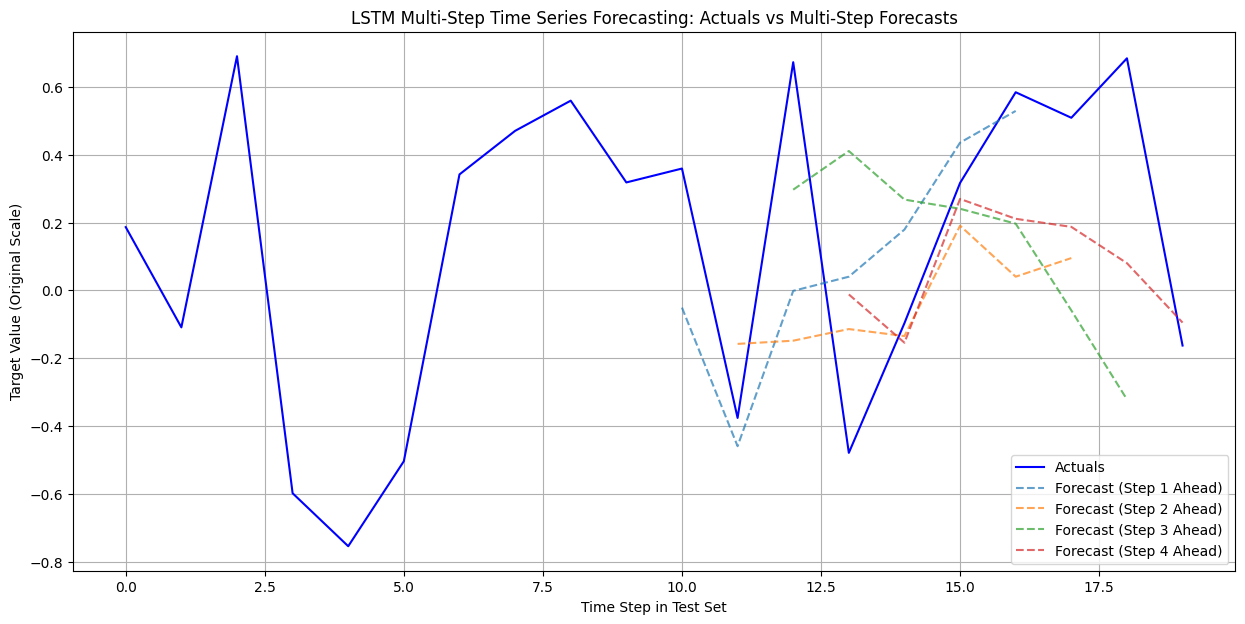

In [57]:
# Prepare the test data for prediction
# We need to combine the scaled test features and the actual test target values.
# First, scale the test features using the same scaler fitted on the training data.
X_test_scaled = scaler.transform(X_test)

# Create a DataFrame from the scaled test features.
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=['feature1', 'feature2'])

# Reset the index of y_test to ensure alignment with X_test_scaled_df
y_test_reset = y_test.reset_index(drop=True)

# Combine the scaled test features and the target into a single DataFrame
test_data_for_sequences = pd.concat([X_test_scaled_df, y_test_reset.rename('target')], axis=1)

# Create a TensorFlow dataset for the test data with the same windowing
test_dataset = tf.data.Dataset.from_tensor_slices(test_data_for_sequences.values)
test_dataset = test_dataset.window(window_size, shift=1, drop_remainder=True)
test_dataset = test_dataset.flat_map(lambda window: window.batch(window_size))
test_dataset = test_dataset.map(lambda window: (window[:sequence_length], window[sequence_length:, -1]))
test_dataset = test_dataset.batch(batch_size).prefetch(1)


# Make predictions on the test data
predictions = model.predict(test_dataset)

# Since the predictions and actuals are scaled, we might want to inverse transform them
# to interpret the results in the original scale.
# However, the scaler was fitted on the features (feature1, feature2), not the target.
# To inverse transform the target, we need to fit a scaler on the target variable (y_train).

# Fit a scaler specifically for the target variable
target_scaler = StandardScaler()
target_scaler.fit(y_train.values.reshape(-1, 1))

# Inverse transform the predictions and actual test target values
predictions_original_scale = target_scaler.inverse_transform(predictions)

# Get the actual target values from the test_dataset for comparison
# We need to extract the actual target values corresponding to the predictions.
# This requires iterating through the test_dataset to get the true y values.
actuals_scaled = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
actuals_original_scale = target_scaler.inverse_transform(actuals_scaled)


# Print the forecast and actuals
print("Forecast (first 5 multi-step predictions):\n", predictions_original_scale[:5])
print("\nActuals (corresponding first 5 multi-step actual values):\n", actuals_original_scale[:5])

# Note: The number of actuals will be less than the number of test data points due to windowing.
# Each prediction is a sequence of 4 values.


# Combined plot: Actuals and multi-step forecasts
plt.figure(figsize=(15, 7))

# Plot the entire actual test series
# We need to use the original y_test data for the complete series.
# Since y_test_reset is aligned with the test_data_for_sequences used for windowing,
# we can plot y_test_reset.values directly.
plt.plot(y_test_reset.values, label='Actuals', color='blue')

# Plot the predictions for each forecast step
num_windows = predictions_original_scale.shape[0]
# The index in the original test set where the actuals_original_scale begins
# This is the end of the first window's input sequence.
start_index_of_actuals_for_plotting = sequence_length

for i in range(forecast_horizon):
    # Extract predictions for the i-th step across all windows
    predictions_step_i = predictions_original_scale[:, i]

    # Determine the correct x-values for plotting these predictions
    # The predictions for step i ahead from window j correspond to the actual value at index
    # (j + sequence_length + i) in the original test set data used for windowing.
    # Since the windows start from index 0 of test_data_for_sequences (aligned with y_test_reset),
    # the x-values will be from `sequence_length + i` up to `sequence_length + i + num_windows - 1`.
    forecast_x_values = range(start_index_of_actuals_for_plotting + i, start_index_of_actuals_for_plotting + i + num_windows)

    plt.plot(forecast_x_values, predictions_step_i, linestyle='--', alpha=0.7, label=f'Forecast (Step {i+1} Ahead)')

plt.title('LSTM Multi-Step Time Series Forecasting: Actuals vs Multi-Step Forecasts')
plt.xlabel('Time Step in Test Set')
plt.ylabel('Target Value (Original Scale)')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

### Subtask:
Evaluate the performance of the model using appropriate metrics.

**Reasoning**:
Calculate the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) to evaluate the performance of the LSTM model on the test data.

In [58]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) for each forecast step
print("Evaluation metrics for each forecast step:")

for i in range(forecast_horizon):
    # Extract predictions and actuals for the i-th step
    predictions_step_i = predictions_original_scale[:, i]
    actuals_step_i = actuals_original_scale[:, i]

    # Calculate Mean Squared Error (MSE) for this step
    mse_step_i = mean_squared_error(actuals_step_i, predictions_step_i)
    print(f"  Step {i+1} Ahead - Mean Squared Error (MSE): {mse_step_i:.6f}")

    # Calculate Root Mean Squared Error (RMSE) for this step
    rmse_step_i = np.sqrt(mse_step_i)
    print(f"  Step {i+1} Ahead - Root Mean Squared Error (RMSE): {rmse_step_i:.6f}")

# You can also keep the overall MSE and RMSE if desired, or remove them.
# For now, let's keep them for comparison.
overall_mse = mean_squared_error(actuals_original_scale, predictions_original_scale)
print(f"\nOverall Mean Squared Error (MSE): {overall_mse:.6f}")

overall_rmse = np.sqrt(overall_mse)
print(f"Overall Root Mean Squared Error (RMSE): {overall_rmse:.6f}")

Evaluation metrics for each forecast step:
  Step 1 Ahead - Mean Squared Error (MSE): 0.069947
  Step 1 Ahead - Root Mean Squared Error (RMSE): 0.264474
  Step 2 Ahead - Mean Squared Error (MSE): 0.057271
  Step 2 Ahead - Root Mean Squared Error (RMSE): 0.239314
  Step 3 Ahead - Mean Squared Error (MSE): 0.137313
  Step 3 Ahead - Root Mean Squared Error (RMSE): 0.370558
  Step 4 Ahead - Mean Squared Error (MSE): 0.023209
  Step 4 Ahead - Root Mean Squared Error (RMSE): 0.152344

Overall Mean Squared Error (MSE): 0.071935
Overall Root Mean Squared Error (RMSE): 0.268207


**Reasoning**:
Create bar charts to visualize the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) for each forecast step.

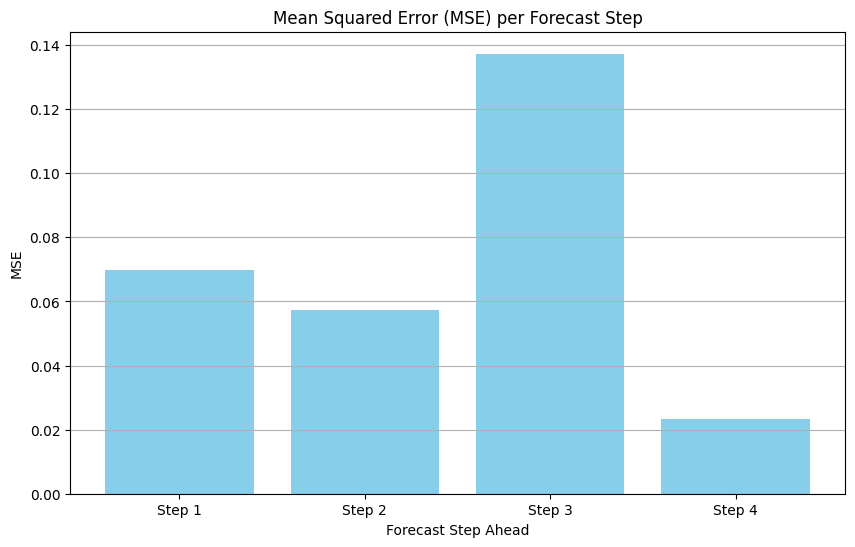

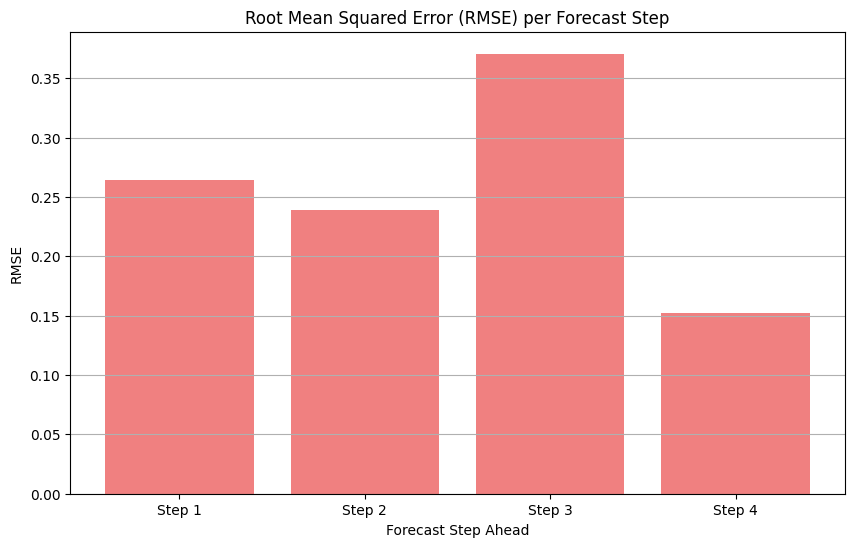

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Extract MSE and RMSE values for each step from the previous output
# Assuming the last execution of cell 11ef1d9e printed the metrics in the format:
#   Step X Ahead - Mean Squared Error (MSE): value
#   Step X Ahead - Root Mean Squared Error (RMSE): value
# We need to capture these values. Since we don't have direct access to the variables
# from the executed cell in this new cell, we'll re-calculate them here for plotting.

# Re-calculate MSE and RMSE for each forecast step (assuming predictions_original_scale and actuals_original_scale are available)
mse_per_step = []
rmse_per_step = []

for i in range(forecast_horizon):
    predictions_step_i = predictions_original_scale[:, i]
    actuals_step_i = actuals_original_scale[:, i]

    mse_step_i = mean_squared_error(actuals_step_i, predictions_step_i)
    rmse_step_i = np.sqrt(mse_step_i)

    mse_per_step.append(mse_step_i)
    rmse_per_step.append(rmse_step_i)

# Create labels for the x-axis
steps_labels = [f'Step {i+1}' for i in range(forecast_horizon)]

# Plotting the MSE bar chart
plt.figure(figsize=(10, 6))
plt.bar(steps_labels, mse_per_step, color='skyblue')
plt.title('Mean Squared Error (MSE) per Forecast Step')
plt.xlabel('Forecast Step Ahead')
plt.ylabel('MSE')
plt.grid(axis='y')
plt.show()

# Plotting the RMSE bar chart
plt.figure(figsize=(10, 6))
plt.bar(steps_labels, rmse_per_step, color='lightcoral')
plt.title('Root Mean Squared Error (RMSE) per Forecast Step')
plt.xlabel('Forecast Step Ahead')
plt.ylabel('RMSE')
plt.grid(axis='y')
plt.show()

**Reasoning**:
Prepare the entire dataset for prediction using the same windowing approach, run the multi-step prediction on the full dataset, and plot the actuals with the overlaid multi-step forecasts.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


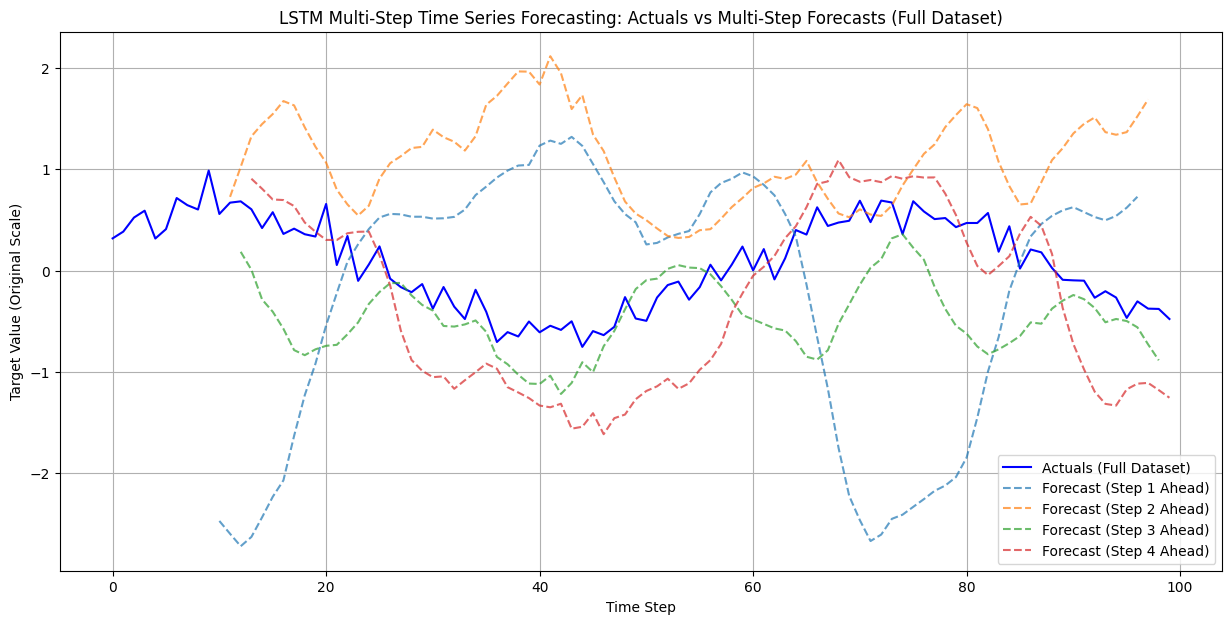

In [60]:
# Prepare the entire dataset for prediction
# Scale the entire feature set using the scaler fitted on the training data.
# We need to re-create the scaler and fit it on the entire dataset for consistent scaling
# if we want to predict on the whole dataset. However, using the scaler fitted on training
# data is more realistic for evaluating performance on unseen data (even if we are now
# applying it to the full dataset for visualization purposes). Let's stick to the scaler
# fitted on the training data for consistency with the previous steps.

# Combine the scaled features and the target into a single DataFrame for the *entire* dataset
# First, scale the features of the entire dataset.
X_scaled_full = scaler.transform(df[['feature1', 'feature2']])

# Create a DataFrame from the scaled full features.
X_scaled_full_df = pd.DataFrame(X_scaled_full, columns=['feature1', 'feature2'])

# Use the original target column from the full dataframe, reset index for concatenation
y_full_reset = df['target'].reset_index(drop=True)

# Combine the scaled full features and the target into a single DataFrame
full_data_for_sequences = pd.concat([X_scaled_full_df, y_full_reset.rename('target')], axis=1)


# Create a TensorFlow dataset for the entire data with the same windowing
# We use the same window_size (sequence_length + forecast_horizon)
full_dataset = tf.data.Dataset.from_tensor_slices(full_data_for_sequences.values)
full_dataset = full_dataset.window(window_size, shift=1, drop_remainder=True)
full_dataset = full_dataset.flat_map(lambda window: window.batch(window_size))
full_dataset = full_dataset.map(lambda window: (window[:sequence_length], window[sequence_length:, -1]))
full_dataset = full_dataset.batch(batch_size).prefetch(1) # Use batching for prediction as well


# Make predictions on the entire dataset
predictions_full = model.predict(full_dataset)

# Inverse transform the predictions back to the original scale using the target scaler
predictions_full_original_scale = target_scaler.inverse_transform(predictions_full)

# Get the actual target values from the full_dataset for comparison
actuals_full_scaled = np.concatenate([y.numpy() for x, y in full_dataset], axis=0)
actuals_full_original_scale = target_scaler.inverse_transform(actuals_full_scaled)


# Combined plot: Entire Actuals and multi-step forecasts
plt.figure(figsize=(15, 7))

# Plot the entire actual time series
# We need to use the original target values for the full plot.
plt.plot(df['target'].values, label='Actuals (Full Dataset)', color='blue')

# Plot the multi-step forecasts
num_windows_full = predictions_full_original_scale.shape[0]
# The starting index for plotting forecasts needs to consider the windowing on the full dataset.
# The actuals corresponding to the predictions start after the first sequence_length + forecast_horizon - 1 points of the full data.
# Similar to the test set plotting, the first window ends at index sequence_length + forecast_horizon - 1 in the original full dataset.
# The plots for each window's forecast should start at the end of that window's input sequence.

for i in range(forecast_horizon):
    # Extract predictions for the i-th step across all windows
    predictions_step_i_full = predictions_full_original_scale[:, i]

    # Determine the correct x-values for plotting these predictions on the full dataset scale
    # The predictions for step i ahead from window j correspond to the actual value at index
    # (j + sequence_length + i) in the original full dataset.
    # Since the windows start from index 0 of full_data_for_sequences (aligned with df['target'].values),
    # the x-values will be from `sequence_length + i` up to `sequence_length + i + num_windows_full - 1`.
    forecast_x_values_full = range(sequence_length + i, sequence_length + i + num_windows_full)

    # Ensure we don't exceed the bounds of the original data when plotting forecast x-values
    # This can happen if the last window's forecast extends beyond the end of the original data.
    # We should only plot forecast points that have a corresponding index in the original data.
    valid_forecast_indices = [idx for idx in forecast_x_values_full if idx < len(df)]
    valid_predictions = predictions_step_i_full[:len(valid_forecast_indices)]


    plt.plot(valid_forecast_indices, valid_predictions, linestyle='--', alpha=0.7, label=f'Forecast (Step {i+1} Ahead)')


plt.title('LSTM Multi-Step Time Series Forecasting: Actuals vs Multi-Step Forecasts (Full Dataset)')
plt.xlabel('Time Step')
plt.ylabel('Target Value (Original Scale)')
plt.legend()
plt.grid(True)
plt.show()

**Reasoning**:
Visualize the original time series data to understand its patterns.